In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import os
from helpers.datasets import *
cm = matplotlib.cm.get_cmap('Greens')

np.random.seed(8)

In [2]:
# directories
curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

# function input paramters
#n_points = 100000
#dataset_id = "skewnorm"
#dataset_config_string = f"{dataset_id}2_npoints{n_points}_nfeatures{n_features}/"


num_signal_to_inject = 500
dataset_config_string = f"LHCO_{num_signal_to_inject}sig/"

data_dir = os.path.join(curtains_dir, dataset_config_string, "data")

print("Making dataset directory at", data_dir, "...")
os.makedirs(data_dir, exist_ok=True)


Making dataset directory at /global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_500sig/data ...


In [3]:
# dataset generation parameters
context_endpoints = (3000, 4000)


bands_dict = {"ob1": [3000, 3200],
              "sb1": [3200, 3400],
              "sr" : [3400, 3600],
              "sb2": [3600, 3800],
              "ob2": [3800, 4000]}

print("Generating datasets...")

# Toy dataset
#data_sim = make_dataset_with_context(n_points, n_features, dataset_id, context_endpoints, .01)
#data_dat = make_dataset_with_context(n_points, n_features, dataset_id, context_endpoints, .0001)

# LHCO dataset
df_sim = get_lhco(sim_type = "herwig")
data_sim = select_lhco_features(df_sim, feature_type = 0).to_numpy()

df_dat = get_lhco(sim_type = "pythia")
data_dat = select_lhco_features(df_dat, feature_type = 0).to_numpy()

df_signal = get_lhco(sim_type = "pythia", sm = "signal")
data_signal = select_lhco_features(df_signal, feature_type = 0).to_numpy()

print("SIM shape:", data_sim.shape)
print("DAT shape:", data_dat.shape)
print("SIGNAL shape:", data_signal.shape)

n_features = data_sim.shape[1]




Generating datasets...
events_anomalydetection_herwig_features.h5
events_anomalydetection_v2.features.h5
events_anomalydetection_v2.features.h5
SIM shape: (999986, 6)
DAT shape: (999881, 6)
SIGNAL shape: (99966, 6)


In [4]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, -1] >= mass_range[0]) & (dataset[:, -1] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data
    
    
    
def minmaxscale(data, col_minmax, lower = -3.0, upper = 3.0):
        
       
        minmaxscaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):

            X_std = (data[:, col] - col_minmax[col][0]) / (col_minmax[col][1] - col_minmax[col][0])
            minmaxscaled_data[:, col] = X_std * (upper - lower) + lower
        
        return minmaxscaled_data
     



## Pull from ob1 -> ob2 to visualize and get column rescales

In [5]:
trial_data_sim = pull_from_mass_range(data_sim, [bands_dict["ob1"], bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"], bands_dict["ob2"]])
trial_data_dat = pull_from_mass_range(data_dat, [bands_dict["ob1"], bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"], bands_dict["ob2"]])
trial_data_sig = pull_from_mass_range(data_signal, [bands_dict["ob1"], bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"], bands_dict["ob2"]])


# list of (min, max) to preprocess every column
col_minmax = []
for col in range(n_features):
            col_minmax.append([np.min(trial_data_sim[:, col]), np.max(trial_data_sim[:, col])])

col_rescales = []
for col in range(n_features):
            col_rescales.append([np.mean(trial_data_sim[:, col]), np.std(trial_data_sim[:, col])])



### Pull n signal events from the range (ob1 -> ob2)

In [6]:
def pull_n_signal_events(n, sig_dataset):
    
    selected_sig_indices = np.random.choice(sig_dataset.shape[0], size=n, replace=False)
    selected_sig_events = sig_dataset[selected_sig_indices]
    
    return(selected_sig_events)




selected_signal = pull_n_signal_events(num_signal_to_inject, trial_data_sig)

data_injected = np.concatenate((data_dat, selected_signal))
np.random.shuffle(data_injected)



## Nice plots of the dataset

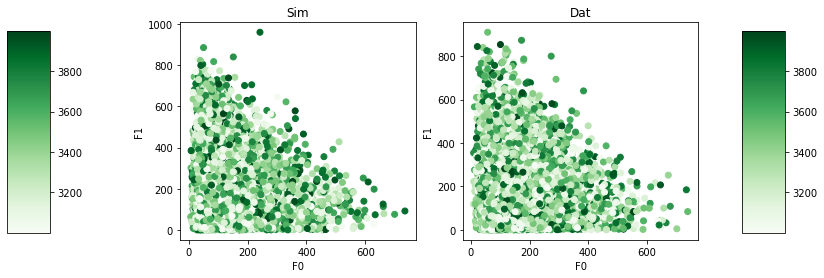

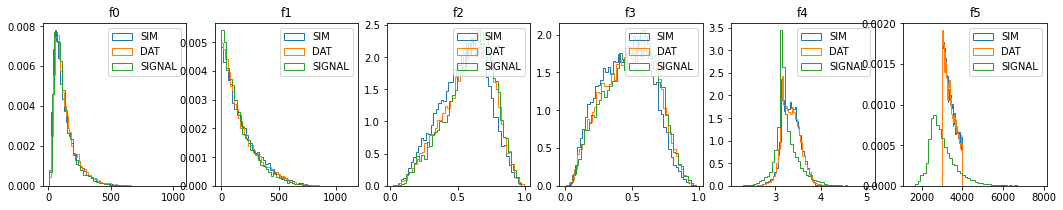

In [7]:


fig, ax = plt.subplots(1, 2, figsize = (12, 4))
fig.subplots_adjust(right=0.8, left = 0.2)

n_plot = 10000

bins = 50




sc_sim = ax[0].scatter(trial_data_sim[:n_plot,0], trial_data_sim[:n_plot,1], c = trial_data_sim[:n_plot,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat[:n_plot,0], trial_data_dat[:n_plot,1], c = trial_data_dat[:n_plot,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()


fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))
for i in range(n_features):
    ax[i].hist(trial_data_sim[:n_plot,i], bins = bins, density = True, label = "SIM", histtype = "step")
    ax[i].hist(trial_data_dat[:n_plot,i], bins = bins, density = True, label = "DAT", histtype = "step")
    ax[i].hist(data_injected[:n_plot,i], bins = bins, density = True, label = "SIGNAL", histtype = "step")
    ax[i].legend()
    #ax[i].set_yscale("log")
    ax[i].set_title(f"f{i}")

fig.show()




# Plot specific bands

SIM sb1 shape: (79793, 6)
DAT sb1 shape: (80037, 6)


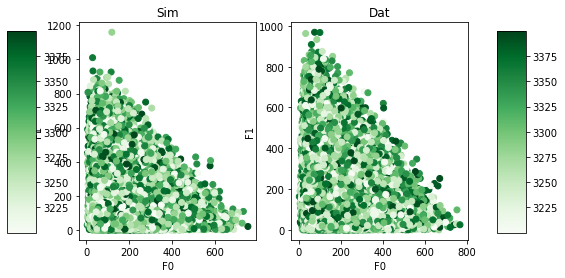

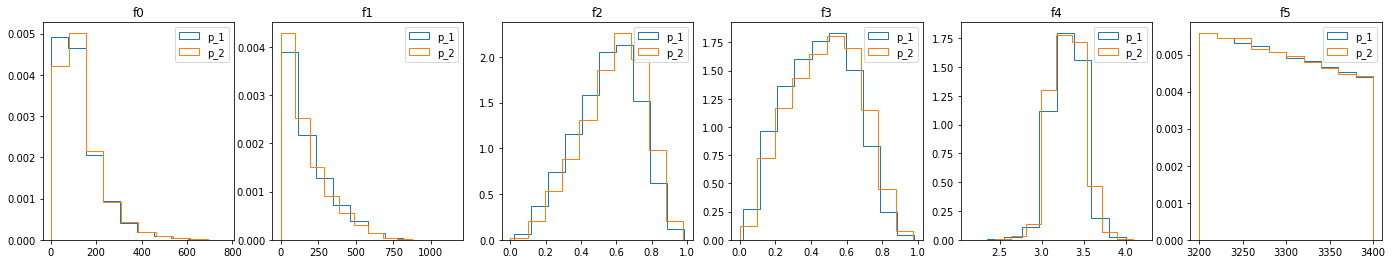

In [8]:


band = "sb1"


trial_data_sim = pull_from_mass_range(data_sim, [bands_dict[band]])
trial_data_dat = pull_from_mass_range(data_dat, [bands_dict[band]])

print(f"SIM {band} shape:", trial_data_sim.shape)
print(f"DAT {band} shape:", trial_data_dat.shape)

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.subplots_adjust(right=0.8)

sc_sim = ax[0].scatter(trial_data_sim[:,0], trial_data_sim[:,1], c = trial_data_sim[:,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat[:,0], trial_data_dat[:,1], c = trial_data_dat[:,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()


fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 4))
for i in range(n_features):
    ax[i].hist(trial_data_sim[:,i], density = True, label = "p_1", histtype = "step")
    ax[i].hist(trial_data_dat[:,i], density = True, label = "p_2", histtype = "step")
    ax[i].legend()
    ax[i].set_title(f"f{i}")

fig.show()






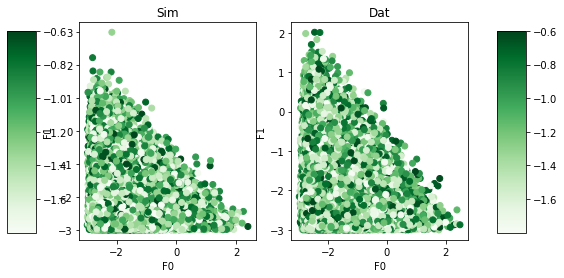

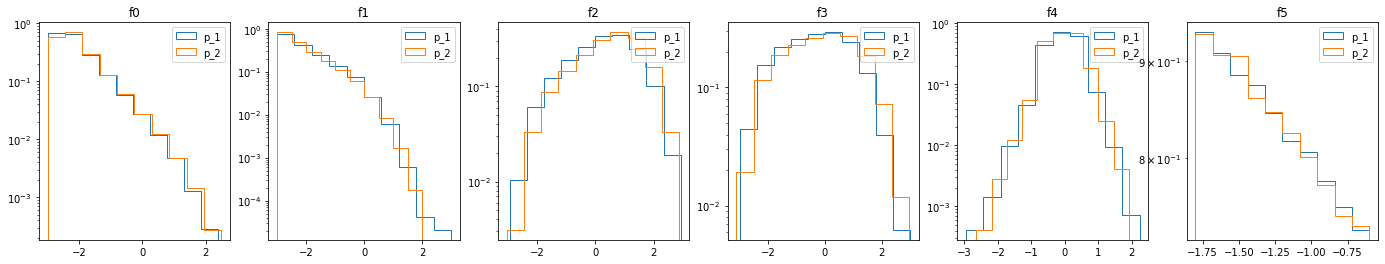

In [9]:
# pull sb1, sb2


trial_data_sim_mms = minmaxscale(trial_data_sim, col_minmax)
trial_data_dat_mms = minmaxscale(trial_data_dat, col_minmax)



fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.subplots_adjust(right=0.8)

sc_sim = ax[0].scatter(trial_data_sim_mms[:,0], trial_data_sim_mms[:,1], c = trial_data_sim_mms[:,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat_mms[:,0], trial_data_dat_mms[:,1], c = trial_data_dat_mms[:,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()


fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 4))
for i in range(n_features):
    ax[i].hist(trial_data_sim_mms[:,i], density = True, label = "p_1", histtype = "step")
    ax[i].hist(trial_data_dat_mms[:,i], density = True, label = "p_2", histtype = "step")
    ax[i].legend()
    ax[i].set_yscale("log")
    ax[i].set_title(f"f{i}")

fig.show()





In [10]:
# save

np.save(os.path.join(data_dir, "data_sim.npy"), data_sim)
np.save(os.path.join(data_dir, "data_dat.npy"), data_injected)
np.save(os.path.join(data_dir, "col_minmax.npy"), col_minmax)
np.save(os.path.join(data_dir, "col_rescales.npy"), col_rescales)


